<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:59:47] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


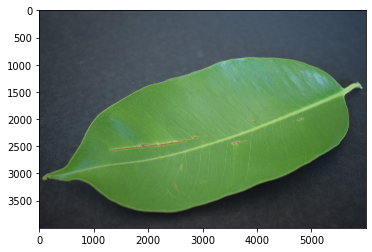

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

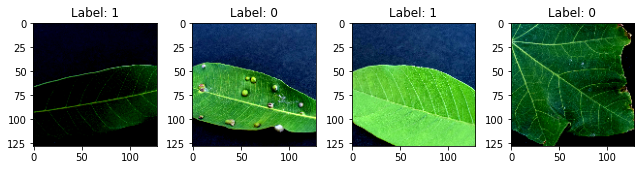

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:59:53] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:59:55] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2151844750430094 samples/sec                   batch loss = 0.39225924015045166 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.265610955884178 samples/sec                   batch loss = 0.5567648410797119 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2703826704982355 samples/sec                   batch loss = 0.45867061614990234 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2677563321637513 samples/sec                   batch loss = 0.5658829808235168 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2700021437681146 samples/sec                   batch loss = 0.38631656765937805 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.2683859348493338 samples/sec                   batch loss = 0.6096747517585754 | accuracy = 0.6416666666666667


Epoch[1] Batch[35] Speed: 1.2647906111331955 samples/sec                   batch loss = 0.7313991189002991 | accuracy = 0.6428571428571429


Epoch[1] Batch[40] Speed: 1.2739224514152947 samples/sec                   batch loss = 0.7153742909431458 | accuracy = 0.6375


Epoch[1] Batch[45] Speed: 1.26072184018984 samples/sec                   batch loss = 0.5362970232963562 | accuracy = 0.6333333333333333


Epoch[1] Batch[50] Speed: 1.2649760926592672 samples/sec                   batch loss = 0.36101555824279785 | accuracy = 0.655


Epoch[1] Batch[55] Speed: 1.2746605501171735 samples/sec                   batch loss = 0.5388261675834656 | accuracy = 0.6681818181818182


Epoch[1] Batch[60] Speed: 1.2690103079948285 samples/sec                   batch loss = 0.839412271976471 | accuracy = 0.6708333333333333


Epoch[1] Batch[65] Speed: 1.277329606180682 samples/sec                   batch loss = 1.2530299425125122 | accuracy = 0.6576923076923077


Epoch[1] Batch[70] Speed: 1.2712348496776755 samples/sec                   batch loss = 0.5285155773162842 | accuracy = 0.6392857142857142


Epoch[1] Batch[75] Speed: 1.2703196663729355 samples/sec                   batch loss = 0.7111304998397827 | accuracy = 0.65


Epoch[1] Batch[80] Speed: 1.2667923903733174 samples/sec                   batch loss = 0.7075602412223816 | accuracy = 0.653125


Epoch[1] Batch[85] Speed: 1.2702497439204337 samples/sec                   batch loss = 1.4481737613677979 | accuracy = 0.638235294117647


Epoch[1] Batch[90] Speed: 1.274692509179043 samples/sec                   batch loss = 0.7949894070625305 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.2590111340417234 samples/sec                   batch loss = 0.7928390502929688 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2672192347157858 samples/sec                   batch loss = 0.4141780734062195 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.267017019511675 samples/sec                   batch loss = 0.3302720785140991 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.2681939878688229 samples/sec                   batch loss = 1.4150073528289795 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.2623337607521206 samples/sec                   batch loss = 0.7184942960739136 | accuracy = 0.6304347826086957


Epoch[1] Batch[120] Speed: 1.2690106919411634 samples/sec                   batch loss = 1.9332231283187866 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2731671394912436 samples/sec                   batch loss = 0.6611815094947815 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.271548363235089 samples/sec                   batch loss = 0.5274698734283447 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.2732011493799287 samples/sec                   batch loss = 0.44477519392967224 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2734009941766014 samples/sec                   batch loss = 0.519851803779602 | accuracy = 0.6267857142857143


Epoch[1] Batch[145] Speed: 1.264840194697088 samples/sec                   batch loss = 0.6184841394424438 | accuracy = 0.6258620689655172


Epoch[1] Batch[150] Speed: 1.2604991533419514 samples/sec                   batch loss = 0.516636848449707 | accuracy = 0.6316666666666667


Epoch[1] Batch[155] Speed: 1.2672230633592045 samples/sec                   batch loss = 0.41254323720932007 | accuracy = 0.6338709677419355


Epoch[1] Batch[160] Speed: 1.267427259284463 samples/sec                   batch loss = 0.8368796110153198 | accuracy = 0.628125


Epoch[1] Batch[165] Speed: 1.2679057930237891 samples/sec                   batch loss = 0.8596142530441284 | accuracy = 0.6242424242424243


Epoch[1] Batch[170] Speed: 1.2722180115451331 samples/sec                   batch loss = 0.5899230241775513 | accuracy = 0.6235294117647059


Epoch[1] Batch[175] Speed: 1.2649909716833263 samples/sec                   batch loss = 0.7367269992828369 | accuracy = 0.6242857142857143


Epoch[1] Batch[180] Speed: 1.2694727476985475 samples/sec                   batch loss = 0.4462727904319763 | accuracy = 0.6277777777777778


Epoch[1] Batch[185] Speed: 1.267166497506863 samples/sec                   batch loss = 0.816819965839386 | accuracy = 0.6270270270270271


Epoch[1] Batch[190] Speed: 1.2694633342289654 samples/sec                   batch loss = 0.7848811149597168 | accuracy = 0.6236842105263158


Epoch[1] Batch[195] Speed: 1.2677595892684101 samples/sec                   batch loss = 0.7938176393508911 | accuracy = 0.6192307692307693


Epoch[1] Batch[200] Speed: 1.2634380993713616 samples/sec                   batch loss = 0.47764235734939575 | accuracy = 0.625


Epoch[1] Batch[205] Speed: 1.265115263358437 samples/sec                   batch loss = 0.5528634190559387 | accuracy = 0.6268292682926829


Epoch[1] Batch[210] Speed: 1.2646653346028318 samples/sec                   batch loss = 0.2768210768699646 | accuracy = 0.6273809523809524


Epoch[1] Batch[215] Speed: 1.273125499175708 samples/sec                   batch loss = 0.730763852596283 | accuracy = 0.6255813953488372


Epoch[1] Batch[220] Speed: 1.2677201219510352 samples/sec                   batch loss = 0.5034583806991577 | accuracy = 0.6284090909090909


Epoch[1] Batch[225] Speed: 1.263155200150339 samples/sec                   batch loss = 0.9191029667854309 | accuracy = 0.6322222222222222


Epoch[1] Batch[230] Speed: 1.2714294526777732 samples/sec                   batch loss = 0.42992958426475525 | accuracy = 0.633695652173913


Epoch[1] Batch[235] Speed: 1.2740162874852083 samples/sec                   batch loss = 0.12361495196819305 | accuracy = 0.6393617021276595


Epoch[1] Batch[240] Speed: 1.2682031907935243 samples/sec                   batch loss = 0.5301579833030701 | accuracy = 0.640625


Epoch[1] Batch[245] Speed: 1.2642567852798607 samples/sec                   batch loss = 0.24910302460193634 | accuracy = 0.6448979591836734


Epoch[1] Batch[250] Speed: 1.26407913393649 samples/sec                   batch loss = 1.2053446769714355 | accuracy = 0.646


Epoch[1] Batch[255] Speed: 1.2640221817704838 samples/sec                   batch loss = 0.46323516964912415 | accuracy = 0.6470588235294118


Epoch[1] Batch[260] Speed: 1.2730983523161183 samples/sec                   batch loss = 1.3196090459823608 | accuracy = 0.6461538461538462


Epoch[1] Batch[265] Speed: 1.2729084532870538 samples/sec                   batch loss = 0.5423744320869446 | accuracy = 0.6462264150943396


Epoch[1] Batch[270] Speed: 1.2730224245434532 samples/sec                   batch loss = 0.7795095443725586 | accuracy = 0.6444444444444445


Epoch[1] Batch[275] Speed: 1.2666117307859996 samples/sec                   batch loss = 0.776968240737915 | accuracy = 0.6463636363636364


Epoch[1] Batch[280] Speed: 1.2668454790841044 samples/sec                   batch loss = 0.7174805998802185 | accuracy = 0.6464285714285715


Epoch[1] Batch[285] Speed: 1.2681294752821868 samples/sec                   batch loss = 0.26824191212654114 | accuracy = 0.6456140350877193


Epoch[1] Batch[290] Speed: 1.2706908555062006 samples/sec                   batch loss = 0.36618712544441223 | accuracy = 0.6517241379310345


Epoch[1] Batch[295] Speed: 1.2689195112109641 samples/sec                   batch loss = 0.6028629541397095 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.267960508341549 samples/sec                   batch loss = 1.034853458404541 | accuracy = 0.6533333333333333


Epoch[1] Batch[305] Speed: 1.2606453922377343 samples/sec                   batch loss = 0.573151171207428 | accuracy = 0.6524590163934426


Epoch[1] Batch[310] Speed: 1.272125887053175 samples/sec                   batch loss = 1.1732897758483887 | accuracy = 0.6516129032258065


Epoch[1] Batch[315] Speed: 1.272403458569076 samples/sec                   batch loss = 0.5700547099113464 | accuracy = 0.6507936507936508


Epoch[1] Batch[320] Speed: 1.2705014815384736 samples/sec                   batch loss = 0.6346749663352966 | accuracy = 0.65078125


Epoch[1] Batch[325] Speed: 1.27032841924402 samples/sec                   batch loss = 0.4529958963394165 | accuracy = 0.6507692307692308


Epoch[1] Batch[330] Speed: 1.2658080428363785 samples/sec                   batch loss = 0.4735942780971527 | accuracy = 0.6522727272727272


Epoch[1] Batch[335] Speed: 1.26721215178645 samples/sec                   batch loss = 0.409594863653183 | accuracy = 0.6544776119402985


Epoch[1] Batch[340] Speed: 1.2725878013216934 samples/sec                   batch loss = 0.4566444456577301 | accuracy = 0.6544117647058824


Epoch[1] Batch[345] Speed: 1.266579793159923 samples/sec                   batch loss = 0.7806288003921509 | accuracy = 0.6557971014492754


Epoch[1] Batch[350] Speed: 1.271237835709268 samples/sec                   batch loss = 0.5744681358337402 | accuracy = 0.6542857142857142


Epoch[1] Batch[355] Speed: 1.267024865750864 samples/sec                   batch loss = 1.2749814987182617 | accuracy = 0.652112676056338


Epoch[1] Batch[360] Speed: 1.2672445041898899 samples/sec                   batch loss = 0.45721977949142456 | accuracy = 0.6534722222222222


Epoch[1] Batch[365] Speed: 1.2665827573628 samples/sec                   batch loss = 0.7315695881843567 | accuracy = 0.6520547945205479


Epoch[1] Batch[370] Speed: 1.269606376388607 samples/sec                   batch loss = 0.5453705191612244 | accuracy = 0.6527027027027027


Epoch[1] Batch[375] Speed: 1.2707621740546835 samples/sec                   batch loss = 0.549911618232727 | accuracy = 0.654


Epoch[1] Batch[380] Speed: 1.2615387160397653 samples/sec                   batch loss = 0.2881600558757782 | accuracy = 0.6526315789473685


Epoch[1] Batch[385] Speed: 1.2639880891167559 samples/sec                   batch loss = 0.5808136463165283 | accuracy = 0.6532467532467533


Epoch[1] Batch[390] Speed: 1.2748498098540055 samples/sec                   batch loss = 0.574344277381897 | accuracy = 0.6538461538461539


Epoch[1] Batch[395] Speed: 1.2715305348703874 samples/sec                   batch loss = 0.4968794882297516 | accuracy = 0.6550632911392406


Epoch[1] Batch[400] Speed: 1.2723716141847625 samples/sec                   batch loss = 0.33924785256385803 | accuracy = 0.658125


Epoch[1] Batch[405] Speed: 1.268506003153645 samples/sec                   batch loss = 0.5587267279624939 | accuracy = 0.658641975308642


Epoch[1] Batch[410] Speed: 1.263698090241359 samples/sec                   batch loss = 0.5874783396720886 | accuracy = 0.6585365853658537


Epoch[1] Batch[415] Speed: 1.2736018685427806 samples/sec                   batch loss = 0.42747485637664795 | accuracy = 0.6578313253012048


Epoch[1] Batch[420] Speed: 1.2725441719296768 samples/sec                   batch loss = 0.6708958745002747 | accuracy = 0.6577380952380952


Epoch[1] Batch[425] Speed: 1.2655125308793302 samples/sec                   batch loss = 0.5220093131065369 | accuracy = 0.6605882352941177


Epoch[1] Batch[430] Speed: 1.25567136725935 samples/sec                   batch loss = 0.4338669776916504 | accuracy = 0.6604651162790698


Epoch[1] Batch[435] Speed: 1.258694611623025 samples/sec                   batch loss = 0.4848836660385132 | accuracy = 0.6609195402298851


Epoch[1] Batch[440] Speed: 1.2606734315499284 samples/sec                   batch loss = 0.269508957862854 | accuracy = 0.6625


Epoch[1] Batch[445] Speed: 1.2693669982750995 samples/sec                   batch loss = 0.24599651992321014 | accuracy = 0.6651685393258427


Epoch[1] Batch[450] Speed: 1.2710989519269853 samples/sec                   batch loss = 0.5442672371864319 | accuracy = 0.665


Epoch[1] Batch[455] Speed: 1.259788994630441 samples/sec                   batch loss = 0.2779248058795929 | accuracy = 0.6653846153846154


Epoch[1] Batch[460] Speed: 1.2582007353671272 samples/sec                   batch loss = 0.8411179184913635 | accuracy = 0.6663043478260869


Epoch[1] Batch[465] Speed: 1.2692111436468732 samples/sec                   batch loss = 0.6995397806167603 | accuracy = 0.6666666666666666


Epoch[1] Batch[470] Speed: 1.2728230848003195 samples/sec                   batch loss = 0.46319517493247986 | accuracy = 0.6691489361702128


Epoch[1] Batch[475] Speed: 1.2648325662034485 samples/sec                   batch loss = 0.3901902437210083 | accuracy = 0.6694736842105263


Epoch[1] Batch[480] Speed: 1.271330216971301 samples/sec                   batch loss = 0.8756536841392517 | accuracy = 0.6697916666666667


Epoch[1] Batch[485] Speed: 1.2648436275492467 samples/sec                   batch loss = 0.5529395937919617 | accuracy = 0.6711340206185566


Epoch[1] Batch[490] Speed: 1.2665486220600986 samples/sec                   batch loss = 0.6707527041435242 | accuracy = 0.6709183673469388


Epoch[1] Batch[495] Speed: 1.2716498498817617 samples/sec                   batch loss = 0.25145646929740906 | accuracy = 0.6732323232323232


Epoch[1] Batch[500] Speed: 1.274635274539547 samples/sec                   batch loss = 1.4246271848678589 | accuracy = 0.674


Epoch[1] Batch[505] Speed: 1.268059410354297 samples/sec                   batch loss = 0.1421322524547577 | accuracy = 0.6752475247524753


Epoch[1] Batch[510] Speed: 1.2571337883494114 samples/sec                   batch loss = 0.724883496761322 | accuracy = 0.6759803921568628


Epoch[1] Batch[515] Speed: 1.2605113701890984 samples/sec                   batch loss = 0.8732740879058838 | accuracy = 0.6762135922330097


Epoch[1] Batch[520] Speed: 1.265574868120378 samples/sec                   batch loss = 0.36193037033081055 | accuracy = 0.6754807692307693


Epoch[1] Batch[525] Speed: 1.2686412510666711 samples/sec                   batch loss = 0.3687136471271515 | accuracy = 0.6761904761904762


Epoch[1] Batch[530] Speed: 1.2634007083146013 samples/sec                   batch loss = 0.7637946605682373 | accuracy = 0.6768867924528302


Epoch[1] Batch[535] Speed: 1.2661112411224498 samples/sec                   batch loss = 1.3142671585083008 | accuracy = 0.6761682242990654


Epoch[1] Batch[540] Speed: 1.2678847130757231 samples/sec                   batch loss = 0.3976208567619324 | accuracy = 0.6773148148148148


Epoch[1] Batch[545] Speed: 1.2736107633868607 samples/sec                   batch loss = 0.6078294515609741 | accuracy = 0.6770642201834862


Epoch[1] Batch[550] Speed: 1.2732678217633178 samples/sec                   batch loss = 0.49618369340896606 | accuracy = 0.6759090909090909


Epoch[1] Batch[555] Speed: 1.2622214103609761 samples/sec                   batch loss = 0.5976471304893494 | accuracy = 0.677027027027027


Epoch[1] Batch[560] Speed: 1.2619846188343269 samples/sec                   batch loss = 0.2467709630727768 | accuracy = 0.678125


Epoch[1] Batch[565] Speed: 1.2676578605487012 samples/sec                   batch loss = 0.5409726500511169 | accuracy = 0.6792035398230089


Epoch[1] Batch[570] Speed: 1.2693760261483404 samples/sec                   batch loss = 0.42204102873802185 | accuracy = 0.6798245614035088


Epoch[1] Batch[575] Speed: 1.2661841488192873 samples/sec                   batch loss = 0.31761908531188965 | accuracy = 0.68


Epoch[1] Batch[580] Speed: 1.2639682819391225 samples/sec                   batch loss = 0.33313286304473877 | accuracy = 0.6814655172413793


Epoch[1] Batch[585] Speed: 1.2659426204954052 samples/sec                   batch loss = 0.6060469746589661 | accuracy = 0.6824786324786325


Epoch[1] Batch[590] Speed: 1.2673184997716485 samples/sec                   batch loss = 0.8642165660858154 | accuracy = 0.6838983050847458


Epoch[1] Batch[595] Speed: 1.2654406549764696 samples/sec                   batch loss = 0.6764219999313354 | accuracy = 0.6836134453781513


Epoch[1] Batch[600] Speed: 1.2642082953210427 samples/sec                   batch loss = 0.30575433373451233 | accuracy = 0.6854166666666667


Epoch[1] Batch[605] Speed: 1.2696335666905476 samples/sec                   batch loss = 0.3005622327327728 | accuracy = 0.6863636363636364


Epoch[1] Batch[610] Speed: 1.2610561602104735 samples/sec                   batch loss = 0.5203017592430115 | accuracy = 0.6864754098360656


Epoch[1] Batch[615] Speed: 1.2623162848215963 samples/sec                   batch loss = 0.9807363748550415 | accuracy = 0.6873983739837398


Epoch[1] Batch[620] Speed: 1.2677365982992888 samples/sec                   batch loss = 0.6340993046760559 | accuracy = 0.6870967741935484


Epoch[1] Batch[625] Speed: 1.2653873021825444 samples/sec                   batch loss = 0.6604796648025513 | accuracy = 0.6876


Epoch[1] Batch[630] Speed: 1.2620455646969997 samples/sec                   batch loss = 0.8630839586257935 | accuracy = 0.6869047619047619


Epoch[1] Batch[635] Speed: 1.2606600748301113 samples/sec                   batch loss = 0.8096620440483093 | accuracy = 0.6858267716535433


Epoch[1] Batch[640] Speed: 1.256070436067272 samples/sec                   batch loss = 0.5509923696517944 | accuracy = 0.68671875


Epoch[1] Batch[645] Speed: 1.2650995228471302 samples/sec                   batch loss = 0.20730528235435486 | accuracy = 0.6875968992248062


Epoch[1] Batch[650] Speed: 1.2635934910069635 samples/sec                   batch loss = 1.1349892616271973 | accuracy = 0.6876923076923077


Epoch[1] Batch[655] Speed: 1.267964724779167 samples/sec                   batch loss = 0.41499292850494385 | accuracy = 0.6896946564885497


Epoch[1] Batch[660] Speed: 1.2634449498811842 samples/sec                   batch loss = 0.3617003262042999 | accuracy = 0.6897727272727273


Epoch[1] Batch[665] Speed: 1.2584875555208501 samples/sec                   batch loss = 1.041438102722168 | accuracy = 0.6902255639097744


Epoch[1] Batch[670] Speed: 1.2599634549965577 samples/sec                   batch loss = 0.2277514636516571 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.2584337490829274 samples/sec                   batch loss = 0.49595963954925537 | accuracy = 0.6914814814814815


Epoch[1] Batch[680] Speed: 1.2646239625705675 samples/sec                   batch loss = 0.5500221848487854 | accuracy = 0.6915441176470588


Epoch[1] Batch[685] Speed: 1.258442716503067 samples/sec                   batch loss = 0.36872726678848267 | accuracy = 0.691970802919708


Epoch[1] Batch[690] Speed: 1.261393502715416 samples/sec                   batch loss = 1.2001922130584717 | accuracy = 0.6916666666666667


Epoch[1] Batch[695] Speed: 1.2713023759492117 samples/sec                   batch loss = 0.35365840792655945 | accuracy = 0.6928057553956835


Epoch[1] Batch[700] Speed: 1.26734137984407 samples/sec                   batch loss = 1.4750341176986694 | accuracy = 0.6921428571428572


Epoch[1] Batch[705] Speed: 1.2722095220286116 samples/sec                   batch loss = 0.9281195998191833 | accuracy = 0.6921985815602837


Epoch[1] Batch[710] Speed: 1.2633716913352433 samples/sec                   batch loss = 0.4422254264354706 | accuracy = 0.6922535211267605


Epoch[1] Batch[715] Speed: 1.2640970396911715 samples/sec                   batch loss = 0.600908637046814 | accuracy = 0.6916083916083916


Epoch[1] Batch[720] Speed: 1.266297301373066 samples/sec                   batch loss = 0.3331943452358246 | accuracy = 0.6930555555555555


Epoch[1] Batch[725] Speed: 1.2708314790986628 samples/sec                   batch loss = 0.48842597007751465 | accuracy = 0.6934482758620689


Epoch[1] Batch[730] Speed: 1.2724910871023611 samples/sec                   batch loss = 0.5519368052482605 | accuracy = 0.6928082191780822


Epoch[1] Batch[735] Speed: 1.263636603971204 samples/sec                   batch loss = 0.519835352897644 | accuracy = 0.6925170068027211


Epoch[1] Batch[740] Speed: 1.2618165261014485 samples/sec                   batch loss = 0.33908671140670776 | accuracy = 0.6922297297297297


Epoch[1] Batch[745] Speed: 1.2645601939334152 samples/sec                   batch loss = 0.3155786395072937 | accuracy = 0.6932885906040268


Epoch[1] Batch[750] Speed: 1.2664585595893276 samples/sec                   batch loss = 0.5689212083816528 | accuracy = 0.6936666666666667


Epoch[1] Batch[755] Speed: 1.2674438237706909 samples/sec                   batch loss = 0.9815529584884644 | accuracy = 0.6930463576158941


Epoch[1] Batch[760] Speed: 1.2670413240316967 samples/sec                   batch loss = 0.7943240404129028 | accuracy = 0.69375


Epoch[1] Batch[765] Speed: 1.2627925820076389 samples/sec                   batch loss = 0.5190290212631226 | accuracy = 0.6934640522875817


Epoch[1] Batch[770] Speed: 1.2657595293067805 samples/sec                   batch loss = 0.7004796266555786 | accuracy = 0.6935064935064935


Epoch[1] Batch[775] Speed: 1.2775202430706631 samples/sec                   batch loss = 0.47867605090141296 | accuracy = 0.6938709677419355


Epoch[1] Batch[780] Speed: 1.271138052058483 samples/sec                   batch loss = 0.5725597739219666 | accuracy = 0.6935897435897436


Epoch[1] Batch[785] Speed: 1.2717635958586386 samples/sec                   batch loss = 0.23144496977329254 | accuracy = 0.6952229299363057


[Epoch 1] training: accuracy=0.695748730964467
[Epoch 1] time cost: 653.7236242294312
[Epoch 1] validation: validation accuracy=0.73


Epoch[2] Batch[5] Speed: 1.2738263079671013 samples/sec                   batch loss = 0.696814239025116 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2700608859819165 samples/sec                   batch loss = 0.37720635533332825 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2653511317381985 samples/sec                   batch loss = 0.27981606125831604 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.263219112499293 samples/sec                   batch loss = 0.5206336975097656 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2669764502642062 samples/sec                   batch loss = 0.35875266790390015 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2678530944678577 samples/sec                   batch loss = 0.47682860493659973 | accuracy = 0.725


Epoch[2] Batch[35] Speed: 1.2717832624804206 samples/sec                   batch loss = 0.4655306041240692 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.267530866249526 samples/sec                   batch loss = 0.1833575963973999 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2593806587233451 samples/sec                   batch loss = 0.5215446352958679 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2727020048003543 samples/sec                   batch loss = 0.8024727702140808 | accuracy = 0.695


Epoch[2] Batch[55] Speed: 1.2776401983975978 samples/sec                   batch loss = 0.4166047275066376 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.2766663222088683 samples/sec                   batch loss = 0.5415221452713013 | accuracy = 0.6916666666666667


Epoch[2] Batch[65] Speed: 1.2682401955681786 samples/sec                   batch loss = 0.618979811668396 | accuracy = 0.6846153846153846


Epoch[2] Batch[70] Speed: 1.274921692911893 samples/sec                   batch loss = 0.5948958992958069 | accuracy = 0.6857142857142857


Epoch[2] Batch[75] Speed: 1.26487681274749 samples/sec                   batch loss = 1.3148338794708252 | accuracy = 0.6933333333333334


Epoch[2] Batch[80] Speed: 1.2657252473817093 samples/sec                   batch loss = 0.45206761360168457 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2700380037533656 samples/sec                   batch loss = 0.2895888388156891 | accuracy = 0.7147058823529412


Epoch[2] Batch[90] Speed: 1.2709496038645705 samples/sec                   batch loss = 0.2046080380678177 | accuracy = 0.7166666666666667


Epoch[2] Batch[95] Speed: 1.2673003111821628 samples/sec                   batch loss = 0.22280937433242798 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.270833308084144 samples/sec                   batch loss = 0.6360838413238525 | accuracy = 0.72


Epoch[2] Batch[105] Speed: 1.2733169125608284 samples/sec                   batch loss = 0.4471619427204132 | accuracy = 0.7238095238095238


Epoch[2] Batch[110] Speed: 1.2720248066284854 samples/sec                   batch loss = 0.6381624937057495 | accuracy = 0.7227272727272728


Epoch[2] Batch[115] Speed: 1.267537761214282 samples/sec                   batch loss = 0.29213860630989075 | accuracy = 0.7304347826086957


Epoch[2] Batch[120] Speed: 1.2619982884222833 samples/sec                   batch loss = 0.8356793522834778 | accuracy = 0.7270833333333333


Epoch[2] Batch[125] Speed: 1.2664286372083824 samples/sec                   batch loss = 0.15631550550460815 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.26454437191914 samples/sec                   batch loss = 1.5134929418563843 | accuracy = 0.7326923076923076


Epoch[2] Batch[135] Speed: 1.2714762818956296 samples/sec                   batch loss = 0.34807518124580383 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2785603125265061 samples/sec                   batch loss = 0.26119667291641235 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.26992975699215 samples/sec                   batch loss = 0.22029845416545868 | accuracy = 0.7396551724137931


Epoch[2] Batch[150] Speed: 1.2704457770773097 samples/sec                   batch loss = 0.16600090265274048 | accuracy = 0.7433333333333333


Epoch[2] Batch[155] Speed: 1.273798164089999 samples/sec                   batch loss = 0.589212954044342 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.2691253103083768 samples/sec                   batch loss = 1.1179780960083008 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2615481072096806 samples/sec                   batch loss = 0.6144900321960449 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.26433786422722 samples/sec                   batch loss = 0.23517349362373352 | accuracy = 0.7382352941176471


Epoch[2] Batch[175] Speed: 1.2709415163833213 samples/sec                   batch loss = 0.4846874177455902 | accuracy = 0.7428571428571429


Epoch[2] Batch[180] Speed: 1.2672169375408393 samples/sec                   batch loss = 0.4101031720638275 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.2702140643146898 samples/sec                   batch loss = 0.6173305511474609 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.2696631602861561 samples/sec                   batch loss = 0.26419928669929504 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2658527396942452 samples/sec                   batch loss = 0.4562534689903259 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.2662119572432362 samples/sec                   batch loss = 0.46173423528671265 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2687917842460092 samples/sec                   batch loss = 0.783432126045227 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2694201109058028 samples/sec                   batch loss = 0.5263159871101379 | accuracy = 0.7523809523809524


Epoch[2] Batch[215] Speed: 1.2707716067968022 samples/sec                   batch loss = 0.15540927648544312 | accuracy = 0.7534883720930232


Epoch[2] Batch[220] Speed: 1.270565273475487 samples/sec                   batch loss = 0.2366952896118164 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2611555048537362 samples/sec                   batch loss = 0.32081127166748047 | accuracy = 0.7488888888888889


Epoch[2] Batch[230] Speed: 1.2629904084125807 samples/sec                   batch loss = 0.20604053139686584 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.2700175258193958 samples/sec                   batch loss = 0.9417397975921631 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.264982864479381 samples/sec                   batch loss = 0.2670074701309204 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.2670030496190279 samples/sec                   batch loss = 0.2722494304180145 | accuracy = 0.7510204081632653


Epoch[2] Batch[250] Speed: 1.2648210282816583 samples/sec                   batch loss = 0.2899385392665863 | accuracy = 0.75


Epoch[2] Batch[255] Speed: 1.2676788371687988 samples/sec                   batch loss = 0.2612149119377136 | accuracy = 0.7519607843137255


Epoch[2] Batch[260] Speed: 1.2710062191154086 samples/sec                   batch loss = 0.7293714284896851 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.2746812749019119 samples/sec                   batch loss = 0.8236338496208191 | accuracy = 0.7490566037735849


Epoch[2] Batch[270] Speed: 1.26812161535616 samples/sec                   batch loss = 0.27525922656059265 | accuracy = 0.7509259259259259


Epoch[2] Batch[275] Speed: 1.2630169357421963 samples/sec                   batch loss = 1.169661045074463 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2661372308455343 samples/sec                   batch loss = 0.16533055901527405 | accuracy = 0.7526785714285714


Epoch[2] Batch[285] Speed: 1.2740092251143875 samples/sec                   batch loss = 0.4092006981372833 | accuracy = 0.7517543859649123


Epoch[2] Batch[290] Speed: 1.2735622299873322 samples/sec                   batch loss = 0.6073793172836304 | accuracy = 0.7508620689655172


Epoch[2] Batch[295] Speed: 1.2708543899284364 samples/sec                   batch loss = 0.3665676414966583 | accuracy = 0.7508474576271187


Epoch[2] Batch[300] Speed: 1.2649507228229095 samples/sec                   batch loss = 0.3967296779155731 | accuracy = 0.7525


Epoch[2] Batch[305] Speed: 1.2643876981642386 samples/sec                   batch loss = 1.3705828189849854 | accuracy = 0.7508196721311475


Epoch[2] Batch[310] Speed: 1.2698468059339993 samples/sec                   batch loss = 0.4019557535648346 | accuracy = 0.7516129032258064


Epoch[2] Batch[315] Speed: 1.2625565262766336 samples/sec                   batch loss = 0.2330012172460556 | accuracy = 0.7507936507936508


Epoch[2] Batch[320] Speed: 1.2587735620289695 samples/sec                   batch loss = 0.3337244391441345 | accuracy = 0.7515625


Epoch[2] Batch[325] Speed: 1.2659499758124193 samples/sec                   batch loss = 0.555196225643158 | accuracy = 0.75


Epoch[2] Batch[330] Speed: 1.2630528777728818 samples/sec                   batch loss = 0.6090948581695557 | accuracy = 0.7507575757575757


Epoch[2] Batch[335] Speed: 1.269010595954558 samples/sec                   batch loss = 0.310569167137146 | accuracy = 0.753731343283582


Epoch[2] Batch[340] Speed: 1.2703057197396546 samples/sec                   batch loss = 0.4134615957736969 | accuracy = 0.7544117647058823


Epoch[2] Batch[345] Speed: 1.2646374987440097 samples/sec                   batch loss = 0.46294406056404114 | accuracy = 0.7521739130434782


Epoch[2] Batch[350] Speed: 1.2660881188098638 samples/sec                   batch loss = 0.16681790351867676 | accuracy = 0.7542857142857143


Epoch[2] Batch[355] Speed: 1.2713703911143288 samples/sec                   batch loss = 0.7121846079826355 | accuracy = 0.752112676056338


Epoch[2] Batch[360] Speed: 1.2673219460895422 samples/sec                   batch loss = 0.40419790148735046 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.2706781518274597 samples/sec                   batch loss = 0.3583705723285675 | accuracy = 0.7513698630136987


Epoch[2] Batch[370] Speed: 1.268955885952309 samples/sec                   batch loss = 1.0214070081710815 | accuracy = 0.7520270270270271


Epoch[2] Batch[375] Speed: 1.2686356871085755 samples/sec                   batch loss = 0.7214617729187012 | accuracy = 0.752


Epoch[2] Batch[380] Speed: 1.26576812395239 samples/sec                   batch loss = 0.3042411506175995 | accuracy = 0.7539473684210526


Epoch[2] Batch[385] Speed: 1.2668416527219226 samples/sec                   batch loss = 0.4241422116756439 | accuracy = 0.7525974025974026


Epoch[2] Batch[390] Speed: 1.2709682824884385 samples/sec                   batch loss = 0.4961075186729431 | accuracy = 0.7506410256410256


Epoch[2] Batch[395] Speed: 1.2697255227361721 samples/sec                   batch loss = 0.5051668286323547 | accuracy = 0.7493670886075949


Epoch[2] Batch[400] Speed: 1.263317846964232 samples/sec                   batch loss = 0.37935110926628113 | accuracy = 0.75


Epoch[2] Batch[405] Speed: 1.261227274032584 samples/sec                   batch loss = 0.7687552571296692 | accuracy = 0.7487654320987654


Epoch[2] Batch[410] Speed: 1.2670084078975967 samples/sec                   batch loss = 0.26979973912239075 | accuracy = 0.749390243902439


Epoch[2] Batch[415] Speed: 1.2706534188786054 samples/sec                   batch loss = 0.4338052272796631 | accuracy = 0.7493975903614458


Epoch[2] Batch[420] Speed: 1.2720569229993528 samples/sec                   batch loss = 0.07504072785377502 | accuracy = 0.7511904761904762


Epoch[2] Batch[425] Speed: 1.271614091579593 samples/sec                   batch loss = 0.1829681098461151 | accuracy = 0.7505882352941177


Epoch[2] Batch[430] Speed: 1.2573143924485068 samples/sec                   batch loss = 0.9686744213104248 | accuracy = 0.7494186046511628


Epoch[2] Batch[435] Speed: 1.270156365690094 samples/sec                   batch loss = 0.29260390996932983 | accuracy = 0.7505747126436781


Epoch[2] Batch[440] Speed: 1.2688613543477927 samples/sec                   batch loss = 0.38682666420936584 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.2641088501474271 samples/sec                   batch loss = 0.6374009847640991 | accuracy = 0.751685393258427


Epoch[2] Batch[450] Speed: 1.2713118167127953 samples/sec                   batch loss = 0.48423704504966736 | accuracy = 0.7511111111111111


Epoch[2] Batch[455] Speed: 1.2644730824528034 samples/sec                   batch loss = 0.13542936742305756 | accuracy = 0.7516483516483516


Epoch[2] Batch[460] Speed: 1.2702893689044101 samples/sec                   batch loss = 0.402888685464859 | accuracy = 0.7516304347826087


Epoch[2] Batch[465] Speed: 1.267343390266487 samples/sec                   batch loss = 0.8312961459159851 | accuracy = 0.7526881720430108


Epoch[2] Batch[470] Speed: 1.2751517344143266 samples/sec                   batch loss = 0.31584882736206055 | accuracy = 0.7526595744680851


Epoch[2] Batch[475] Speed: 1.2747036468044304 samples/sec                   batch loss = 0.22722186148166656 | accuracy = 0.7526315789473684


Epoch[2] Batch[480] Speed: 1.2664575079800817 samples/sec                   batch loss = 0.5011128783226013 | accuracy = 0.7510416666666667


Epoch[2] Batch[485] Speed: 1.269785200400132 samples/sec                   batch loss = 0.3983938694000244 | accuracy = 0.75


Epoch[2] Batch[490] Speed: 1.2695315370138553 samples/sec                   batch loss = 0.7914286255836487 | accuracy = 0.75


Epoch[2] Batch[495] Speed: 1.2706994210087226 samples/sec                   batch loss = 0.24234524369239807 | accuracy = 0.75


Epoch[2] Batch[500] Speed: 1.2621617768589601 samples/sec                   batch loss = 0.41361168026924133 | accuracy = 0.7505


Epoch[2] Batch[505] Speed: 1.268161395251346 samples/sec                   batch loss = 0.7093009948730469 | accuracy = 0.7495049504950495


Epoch[2] Batch[510] Speed: 1.268954254322932 samples/sec                   batch loss = 0.8178665041923523 | accuracy = 0.7490196078431373


Epoch[2] Batch[515] Speed: 1.2677123628888538 samples/sec                   batch loss = 0.08072111010551453 | accuracy = 0.7495145631067961


Epoch[2] Batch[520] Speed: 1.2727750941975722 samples/sec                   batch loss = 0.26720476150512695 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.27245788720709 samples/sec                   batch loss = 0.30349621176719666 | accuracy = 0.7514285714285714


Epoch[2] Batch[530] Speed: 1.268350551642605 samples/sec                   batch loss = 0.9446160793304443 | accuracy = 0.7504716981132076


Epoch[2] Batch[535] Speed: 1.2652702090508379 samples/sec                   batch loss = 0.26781222224235535 | accuracy = 0.7509345794392523


Epoch[2] Batch[540] Speed: 1.2656604128291669 samples/sec                   batch loss = 0.5780285000801086 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2753287309992567 samples/sec                   batch loss = 0.3970631957054138 | accuracy = 0.7513761467889908


Epoch[2] Batch[550] Speed: 1.2718866186468747 samples/sec                   batch loss = 0.4542965292930603 | accuracy = 0.75


Epoch[2] Batch[555] Speed: 1.2595707034097912 samples/sec                   batch loss = 0.7625847458839417 | accuracy = 0.7504504504504504


Epoch[2] Batch[560] Speed: 1.2679635748388538 samples/sec                   batch loss = 1.0724910497665405 | accuracy = 0.7508928571428571


Epoch[2] Batch[565] Speed: 1.2770423966223245 samples/sec                   batch loss = 0.06948115676641464 | accuracy = 0.7513274336283186


Epoch[2] Batch[570] Speed: 1.2697574270052139 samples/sec                   batch loss = 0.2753816843032837 | accuracy = 0.7530701754385964


Epoch[2] Batch[575] Speed: 1.266565546055828 samples/sec                   batch loss = 0.6264021992683411 | accuracy = 0.7534782608695653


Epoch[2] Batch[580] Speed: 1.2659744304678702 samples/sec                   batch loss = 0.9409345984458923 | accuracy = 0.7521551724137931


Epoch[2] Batch[585] Speed: 1.2657840721040234 samples/sec                   batch loss = 0.12589460611343384 | accuracy = 0.7512820512820513


Epoch[2] Batch[590] Speed: 1.2654521087567299 samples/sec                   batch loss = 0.4428713321685791 | accuracy = 0.7508474576271187


Epoch[2] Batch[595] Speed: 1.2648644157742854 samples/sec                   batch loss = 0.6384332776069641 | accuracy = 0.75


Epoch[2] Batch[600] Speed: 1.2701612698693416 samples/sec                   batch loss = 0.27163511514663696 | accuracy = 0.7504166666666666


Epoch[2] Batch[605] Speed: 1.2722811076385099 samples/sec                   batch loss = 0.5721248388290405 | accuracy = 0.7508264462809917


Epoch[2] Batch[610] Speed: 1.265956089387709 samples/sec                   batch loss = 0.3315611779689789 | accuracy = 0.7504098360655738


Epoch[2] Batch[615] Speed: 1.2655828874455899 samples/sec                   batch loss = 0.7949449419975281 | accuracy = 0.751219512195122


Epoch[2] Batch[620] Speed: 1.2685870525182381 samples/sec                   batch loss = 0.20999574661254883 | accuracy = 0.7524193548387097


Epoch[2] Batch[625] Speed: 1.2711790808910914 samples/sec                   batch loss = 0.7625086903572083 | accuracy = 0.752


Epoch[2] Batch[630] Speed: 1.2668706379910712 samples/sec                   batch loss = 0.6008117198944092 | accuracy = 0.7527777777777778


Epoch[2] Batch[635] Speed: 1.256895511801308 samples/sec                   batch loss = 1.1371262073516846 | accuracy = 0.7515748031496063


Epoch[2] Batch[640] Speed: 1.2657577148965173 samples/sec                   batch loss = 0.6104493141174316 | accuracy = 0.7515625


Epoch[2] Batch[645] Speed: 1.2635323955533753 samples/sec                   batch loss = 0.09580288827419281 | accuracy = 0.7531007751937985


Epoch[2] Batch[650] Speed: 1.27024397349792 samples/sec                   batch loss = 0.6827149987220764 | accuracy = 0.7530769230769231


Epoch[2] Batch[655] Speed: 1.2597327121425046 samples/sec                   batch loss = 0.1114153265953064 | accuracy = 0.7541984732824427


Epoch[2] Batch[660] Speed: 1.2617568359574034 samples/sec                   batch loss = 1.3608571290969849 | accuracy = 0.7537878787878788


Epoch[2] Batch[665] Speed: 1.2617282739911793 samples/sec                   batch loss = 0.3249875009059906 | accuracy = 0.7533834586466165


Epoch[2] Batch[670] Speed: 1.2626945948606576 samples/sec                   batch loss = 1.9196932315826416 | accuracy = 0.753731343283582


Epoch[2] Batch[675] Speed: 1.2646121424870969 samples/sec                   batch loss = 0.7468682527542114 | accuracy = 0.752962962962963


Epoch[2] Batch[680] Speed: 1.2624484110563985 samples/sec                   batch loss = 1.1655185222625732 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.2566430184330986 samples/sec                   batch loss = 0.27395492792129517 | accuracy = 0.7543795620437956


Epoch[2] Batch[690] Speed: 1.2593025773824602 samples/sec                   batch loss = 0.4956910312175751 | accuracy = 0.7543478260869565


Epoch[2] Batch[695] Speed: 1.2572478728527132 samples/sec                   batch loss = 0.4955030083656311 | accuracy = 0.7532374100719424


Epoch[2] Batch[700] Speed: 1.2655544383939696 samples/sec                   batch loss = 0.2772195041179657 | accuracy = 0.7539285714285714


Epoch[2] Batch[705] Speed: 1.272708956138722 samples/sec                   batch loss = 0.506754457950592 | accuracy = 0.7535460992907801


Epoch[2] Batch[710] Speed: 1.2649306947235344 samples/sec                   batch loss = 0.4922793209552765 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.2670504145445274 samples/sec                   batch loss = 0.31170326471328735 | accuracy = 0.7541958041958042


Epoch[2] Batch[720] Speed: 1.2628591192918686 samples/sec                   batch loss = 0.1360185146331787 | accuracy = 0.7552083333333334


Epoch[2] Batch[725] Speed: 1.2747529452401238 samples/sec                   batch loss = 0.7029072046279907 | accuracy = 0.7551724137931034


Epoch[2] Batch[730] Speed: 1.2692102794950095 samples/sec                   batch loss = 0.6129330396652222 | accuracy = 0.7558219178082192


Epoch[2] Batch[735] Speed: 1.2689017564877505 samples/sec                   batch loss = 0.3679710626602173 | accuracy = 0.7561224489795918


Epoch[2] Batch[740] Speed: 1.265869454073758 samples/sec                   batch loss = 0.6671707630157471 | accuracy = 0.7550675675675675


Epoch[2] Batch[745] Speed: 1.2693800599204441 samples/sec                   batch loss = 0.5012717843055725 | accuracy = 0.7546979865771812


Epoch[2] Batch[750] Speed: 1.269279895499293 samples/sec                   batch loss = 0.2723890542984009 | accuracy = 0.756


Epoch[2] Batch[755] Speed: 1.2687989807993112 samples/sec                   batch loss = 0.40572983026504517 | accuracy = 0.7556291390728477


Epoch[2] Batch[760] Speed: 1.267500893177349 samples/sec                   batch loss = 0.3029730021953583 | accuracy = 0.7552631578947369


Epoch[2] Batch[765] Speed: 1.270347752936179 samples/sec                   batch loss = 0.2000771462917328 | accuracy = 0.7549019607843137


Epoch[2] Batch[770] Speed: 1.2620622736251488 samples/sec                   batch loss = 0.3090374171733856 | accuracy = 0.7558441558441559


Epoch[2] Batch[775] Speed: 1.2700014708118783 samples/sec                   batch loss = 0.23353694379329681 | accuracy = 0.7564516129032258


Epoch[2] Batch[780] Speed: 1.2692503197672242 samples/sec                   batch loss = 0.6206243634223938 | accuracy = 0.7564102564102564


Epoch[2] Batch[785] Speed: 1.2637102739896795 samples/sec                   batch loss = 0.53641277551651 | accuracy = 0.7563694267515924


[Epoch 2] training: accuracy=0.7563451776649747
[Epoch 2] time cost: 639.562965631485
[Epoch 2] validation: validation accuracy=0.7511111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7555555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)